In [1]:
import fasttext

model = fasttext.load_model('model.ftz')

In [4]:
import pandas as pd

falsely_predicted_dict = dict()
not_predicted_dict = dict()

falsely_predicted_by_number_of_true_labels = { 1: dict(), 2: dict(), 3: dict()}
not_predicted_by_number_of_true_labels = { 1: dict(), 2: dict(), 3: dict()}

def hamming_loss(test_df):
    not_predicted = 0
    falsely_predicted = 0
    number_of_true_labels = 0
    number_of_predicted_labels = 0
    
    for index, row in test_df.iterrows():
        predict = model.predict(row['storyline'],3)
        true_labels = len(row['genre'].split(" "))
        number_of_true_labels += true_labels
        genres = []
        for i,p in enumerate(predict[1]):
            if(p > 0.176):
                genres.append(predict[0][i][9:])

        number_of_predicted_labels += len(genres)
        
        results = calculate_errors(genres, row['genre'].split(" "))
        not_predicted += results[0]
        falsely_predicted += results[1]
        
        if results[1] in falsely_predicted_by_number_of_true_labels[true_labels]:
            falsely_predicted_by_number_of_true_labels[true_labels][results[1]] += 1
        else:
            falsely_predicted_by_number_of_true_labels[true_labels][results[1]] = 1
            
        if results[0] in not_predicted_by_number_of_true_labels[true_labels]:
            not_predicted_by_number_of_true_labels[true_labels][results[0]] += 1
        else:
            not_predicted_by_number_of_true_labels[true_labels][results[0]] = 1
        
        
        
    return (not_predicted + falsely_predicted) / (28*len(test_df)), not_predicted, falsely_predicted, number_of_true_labels, number_of_predicted_labels
                
def calculate_errors(predicted, actual):
    not_predicted = 0
    falsely_predicted = 0
    
    for genre in actual:
        if genre not in predicted:
            not_predicted += 1
            if genre in not_predicted_dict:
                not_predicted_dict[genre] += 1
            else:
                not_predicted_dict[genre] = 1
    for genre in predicted:
        if genre not in actual:
            falsely_predicted += 1
            if genre in falsely_predicted_dict:
                falsely_predicted_dict[genre] += 1
            else:
                falsely_predicted_dict[genre] = 1
    
    return not_predicted, falsely_predicted

def print_evaluation_results(results):    
    hl, np, fp, ntl, npl = results
    print("Hamming loss\t\t\t{:.6f}".format(hl))
    print("Not predicted\t\t\t{}".format(np))
    print("Falsely predicted\t\t{}".format(fp))
    print("True number of labels\t\t{}".format(ntl))
    print("Predicted number of labels\t{}".format(npl))
  
df = pd.read_csv('dataset_test.csv')

print_evaluation_results(hamming_loss(df))

print(falsely_predicted_dict)
print(not_predicted_dict)
print(not_predicted_by_number_of_true_labels)
print(falsely_predicted_by_number_of_true_labels)

Hamming loss			0.007772
Not predicted			475
Falsely predicted		155
True number of labels		8144
Predicted number of labels	7824
{'Comedy': 12, 'Thriller': 4, 'Crime': 89, 'Action': 8, 'Sci-Fi': 2, 'Romance': 3, 'Drama': 26, 'Adventure': 4, 'Family': 3, 'Mystery': 2, 'Fantasy': 1, 'History': 1}
{'Drama': 108, 'Fantasy': 12, 'Music': 10, 'Thriller': 42, 'Musical': 8, 'Biography': 54, 'Horror': 24, 'Action': 25, 'History': 22, 'War': 1, 'Crime': 15, 'Comedy': 65, 'Sci-Fi': 17, 'Romance': 22, 'Mystery': 12, 'Adventure': 18, 'Sport': 8, 'Family': 7, 'Western': 4, 'Animation': 1}
{1: {1: 3, 0: 44}, 2: {0: 375, 1: 38, 2: 34}, 3: {0: 2230, 3: 69, 1: 45, 2: 57}}
{1: {2: 2, 0: 41, 1: 4}, 2: {0: 393, 2: 7, 1: 47}, 3: {0: 2319, 1: 78, 2: 4}}


In [ ]:
#plot
import matplotlib
import numpy as np
import matplotlib.pylab as plt
import operator

listOfGenres = ["Action", "Drama", "Comedy", "Crime", 
                "Mystery", "Adventure", "Animation", "Horror", 
                "War", "Documentary", "Sport", "Talk-Show", 
                "News", "Film-Noir", "Romance", "Short", 
                "Thriller", "Family", "Fantasy", "Sci-Fi", 
                "History", "Music", "Biography", "Music", 
                "Reality-TV", "Western", "Game-Show", "Adult"]

for genre in listOfGenres:
    if genre not in not_predicted_dict:
        if genre in falsely_predicted_dict:
            not_predicted_dict[genre] = 0
    if genre not in falsely_predicted_dict:
        if genre in not_predicted_dict:
            falsely_predicted_dict[genre] = 0


def sort_by_another_dict(sorted_dict, dict_to_sort):
    output = dict()
    for key in sorted_dict.keys():
        output[key] = dict_to_sort[key]
    return output

sorted_false = dict(sorted(falsely_predicted_dict.items(), key=operator.itemgetter(1)))
sorted_not = sort_by_another_dict(sorted_false, not_predicted_dict)

print(sorted_false)
print(sorted_not)

labels = list(sorted_false.keys())
false_values = list(sorted_false.values())
not_values = list(sorted_not.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width/2, false_values, width, label='Falsely predicted')
rects2 = ax.bar(x + width/2, not_values, width, label='Not predicted')

ax.set_ylabel('Count')
ax.set_xlabel('Genre')
ax.set_title('Mistakes by genre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects, c):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color=c)
        
autolabel(rects1, (0.0, 0.0, 0.5, 1.0))
autolabel(rects2, (1.0, 0.27, 0.0, 1.0))

fig.tight_layout()

plt.savefig('results_176.png')
plt.show()

{'Animation': 0, 'Horror': 0, 'War': 0, 'Sport': 0, 'Music': 0, 'Biography': 0, 'Western': 0, 'Fantasy': 1, 'History': 1, 'Sci-Fi': 2, 'Mystery': 2, 'Romance': 3, 'Family': 3, 'Thriller': 4, 'Adventure': 4, 'Action': 8, 'Comedy': 12, 'Drama': 26, 'Crime': 89}
{'Animation': 1, 'Horror': 24, 'War': 1, 'Sport': 8, 'Music': 10, 'Biography': 54, 'Western': 4, 'Fantasy': 12, 'History': 22, 'Sci-Fi': 17, 'Mystery': 12, 'Romance': 22, 'Family': 7, 'Thriller': 42, 'Adventure': 18, 'Action': 25, 'Comedy': 65, 'Drama': 108, 'Crime': 15}


In [66]:
print(not_predicted_by_number_of_true_labels)
print(falsely_predicted_by_number_of_true_labels)

{1: {1: 3, 0: 44}, 2: {0: 375, 1: 38, 2: 34}, 3: {0: 2230, 3: 69, 1: 45, 2: 57}}
{1: {2: 2, 0: 41, 1: 4}, 2: {0: 394, 2: 7, 1: 46}, 3: {0: 2319, 1: 78, 2: 4}}


{1: {0: 44, 1: 3}, 2: {0: 375, 1: 38, 2: 34}, 3: {0: 2230, 1: 45, 2: 57, 3: 69}}
[{0: 44, 1: 3}, {0: 375, 1: 38, 2: 34}, {0: 2230, 1: 45, 2: 57, 3: 69}]


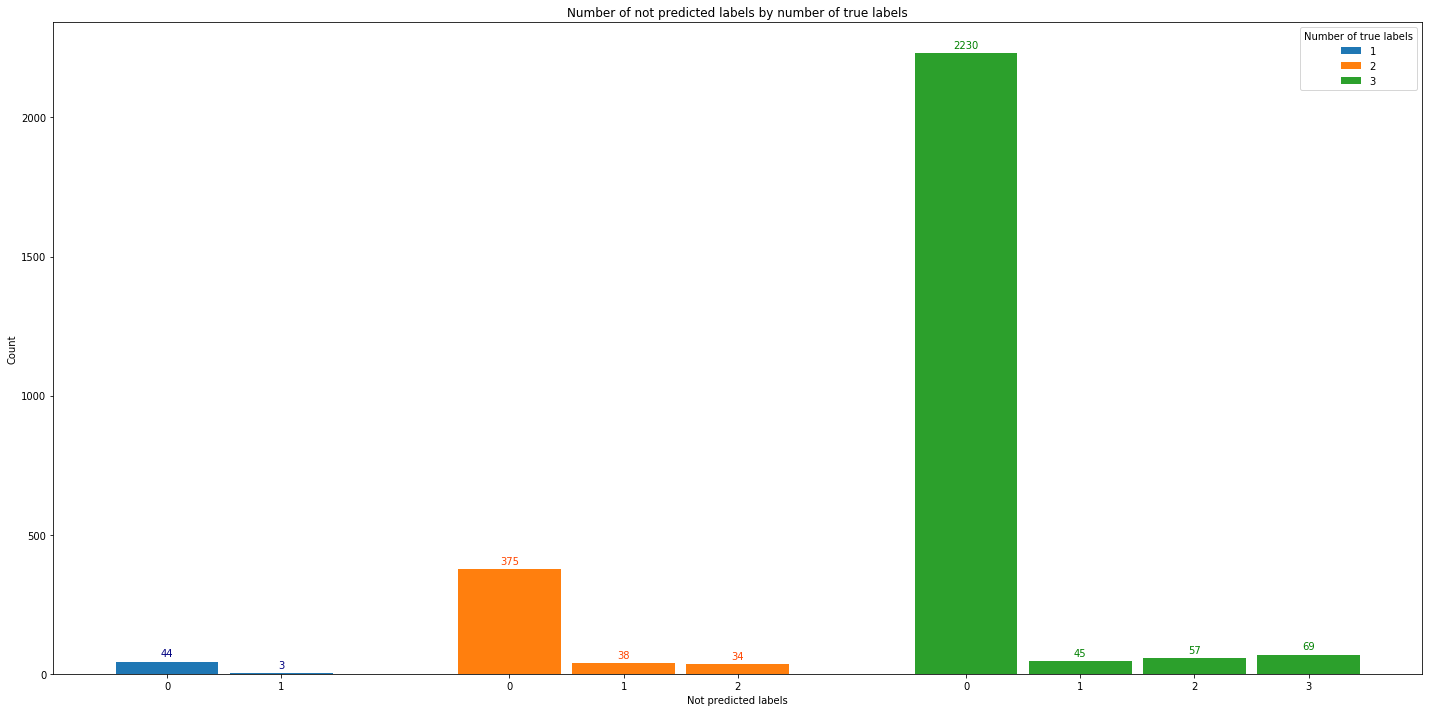

In [67]:
sorted_not_predicted_by_number_of_true_labels = dict()

for key in not_predicted_by_number_of_true_labels:
    sorted_not_predicted_by_number_of_true_labels[key] = dict(sorted(not_predicted_by_number_of_true_labels[key].items(), key=operator.itemgetter(0)))
print(sorted_not_predicted_by_number_of_true_labels)

labels = [0, 1, 0, 1, 2, 0, 1, 2, 3]
print(list(sorted_not_predicted_by_number_of_true_labels.values()))

y1 = list(sorted_not_predicted_by_number_of_true_labels[1].values())
y2 = list(sorted_not_predicted_by_number_of_true_labels[2].values())
y3 = list(sorted_not_predicted_by_number_of_true_labels[3].values())

width = 0.9
groupgap = 1

x1 = np.arange(len(y1))
x2 = np.arange(len(y2)) + groupgap + len(y1)
x3 = np.arange(len(y3)) + 2 * groupgap + len(y1) + len(y2)

ind = np.concatenate((x1, x2, x3))

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x1, y1, width, label='1')
rects2 = ax.bar(x2, y2, width, label='2')
rects3 = ax.bar(x3, y3, width, label='3')

ax.set_ylabel('Count')
ax.set_xlabel('Not predicted labels')
ax.set_title('Number of not predicted labels by number of true labels')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend(title='Number of true labels')
        
autolabel(rects1, (0.0, 0.0, 0.5, 1.0))
autolabel(rects2, (1.0, 0.27, 0.0, 1.0))
autolabel(rects3, (0.0, 0.5, 0.0, 1.0))

fig.tight_layout()

plt.savefig('not_predicted_by_number_of_true_labels.png')
plt.show()

{1: {0: 41, 1: 4, 2: 2}, 2: {0: 394, 1: 46, 2: 7}, 3: {0: 2319, 1: 78, 2: 4}}
[{0: 41, 1: 4, 2: 2}, {0: 394, 1: 46, 2: 7}, {0: 2319, 1: 78, 2: 4}]


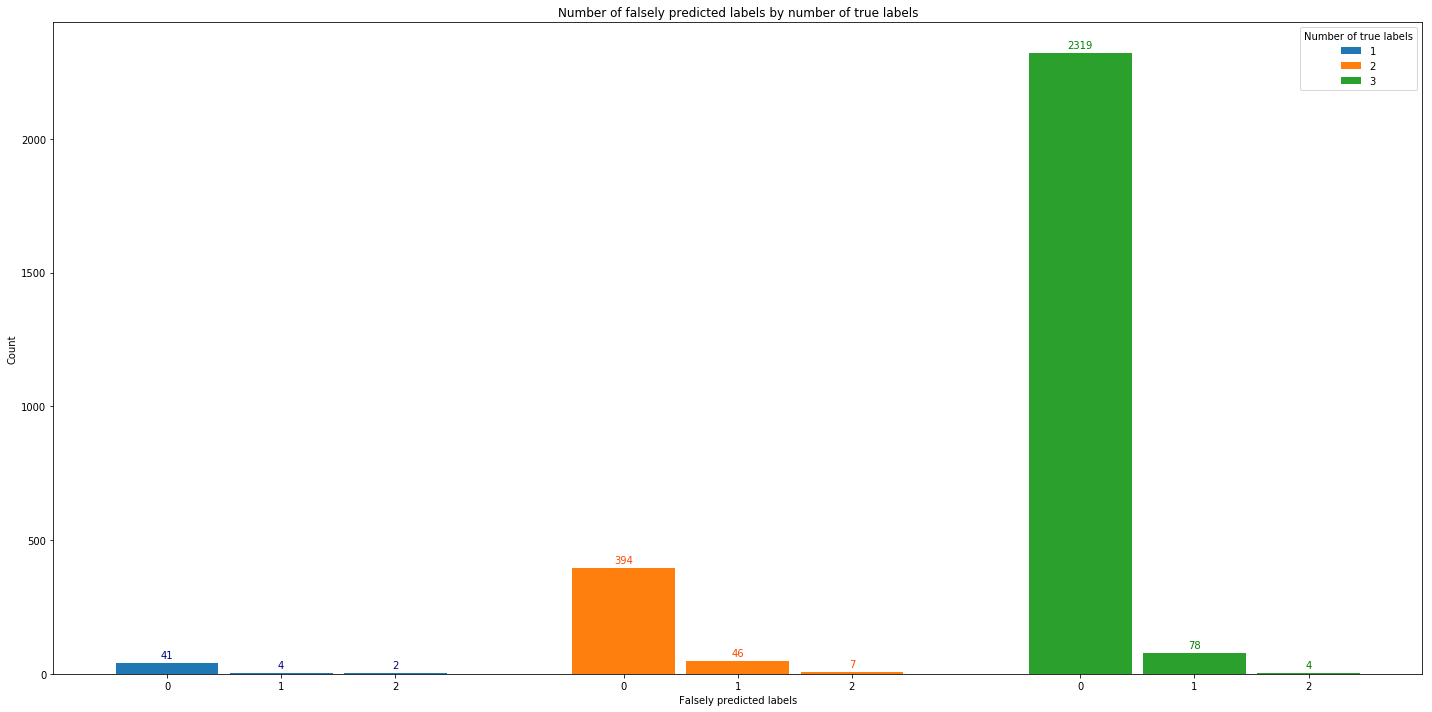

In [68]:
sorted_falsely_predicted_by_number_of_true_labels = dict()

for key in falsely_predicted_by_number_of_true_labels:
    sorted_falsely_predicted_by_number_of_true_labels[key] = dict(sorted(falsely_predicted_by_number_of_true_labels[key].items(), key=operator.itemgetter(0)))
print(sorted_falsely_predicted_by_number_of_true_labels)

labels = [0, 1, 2, 0, 1, 2, 0, 1, 2]
print(list(sorted_falsely_predicted_by_number_of_true_labels.values()))

y1 = list(sorted_falsely_predicted_by_number_of_true_labels[1].values())
y2 = list(sorted_falsely_predicted_by_number_of_true_labels[2].values())
y3 = list(sorted_falsely_predicted_by_number_of_true_labels[3].values())

width = 0.9
groupgap = 1

x1 = np.arange(len(y1))
x2 = np.arange(len(y2)) + groupgap + len(y1)
x3 = np.arange(len(y3)) + 2 * groupgap + len(y1) + len(y2)

ind = np.concatenate((x1, x2, x3))

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x1, y1, width, label='1')
rects2 = ax.bar(x2, y2, width, label='2')
rects3 = ax.bar(x3, y3, width, label='3')

ax.set_ylabel('Count')
ax.set_xlabel('Falsely predicted labels')
ax.set_title('Number of falsely predicted labels by number of true labels')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend(title='Number of true labels')
        
autolabel(rects1, (0.0, 0.0, 0.5, 1.0))
autolabel(rects2, (1.0, 0.27, 0.0, 1.0))
autolabel(rects3, (0.0, 0.5, 0.0, 1.0))

fig.tight_layout()

plt.savefig('falsely_predicted_by_number_of_true_labels.png')
plt.show()

In [49]:
import numpy as np

falsely_predicted_dict = dict()
not_predicted_dict = dict()

falsely_predicted_by_number_of_true_labels = { 1: dict(), 2: dict(), 3: dict()}
not_predicted_by_number_of_true_labels = { 1: dict(), 2: dict(), 3: dict()}

def hamming_loss(test_df):
    not_predicted = 0
    falsely_predicted = 0
    number_of_true_labels = 0
    number_of_predicted_labels = 0
    
    hl_list = []
    
    for threshold in np.arange(0.05, 0.302, 0.002):
        
        for (index, row) in test_df.iterrows():
            predict = model.predict(row['storyline'], 3)
            true_labels = len(row['genre'].split(' '))
            number_of_true_labels += true_labels
            genres = []
            for (i, p) in enumerate(predict[1]):
                if p > threshold:
                    genres.append((predict[0][i])[9:])

            number_of_predicted_labels += len(genres)

            results = calculate_errors(genres, row['genre'].split(' '))
            not_predicted += results[0]
            falsely_predicted += results[1]

            if results[1] \
                in falsely_predicted_by_number_of_true_labels[true_labels]:
                falsely_predicted_by_number_of_true_labels[true_labels][results[1]] += \
                    1
            else:
                falsely_predicted_by_number_of_true_labels[true_labels][results[1]] = \
                    1

            if results[0] \
                in not_predicted_by_number_of_true_labels[true_labels]:
                not_predicted_by_number_of_true_labels[true_labels][results[0]] += \
                    1
            else:
                not_predicted_by_number_of_true_labels[true_labels][results[0]] = \
                    1

        hl_list.append((not_predicted + falsely_predicted) / (28
                       * len(test_df)))
        not_predicted = 0
        falsely_predicted = 0
        number_of_true_labels = 0
        number_of_predicted_labels = 0
        
        
    return hl_list
                
def calculate_errors(predicted, actual):
    not_predicted = 0
    falsely_predicted = 0
    
    for genre in actual:
        if genre not in predicted:
            not_predicted += 1
            if genre in not_predicted_dict:
                not_predicted_dict[genre] += 1
            else:
                not_predicted_dict[genre] = 1
    for genre in predicted:
        if genre not in actual:
            falsely_predicted += 1
            if genre in falsely_predicted_dict:
                falsely_predicted_dict[genre] += 1
            else:
                falsely_predicted_dict[genre] = 1
    
    return not_predicted, falsely_predicted
  
df = pd.read_csv('dataset_test.csv')

results = hamming_loss(df)

In [50]:
print(results)

[0.009733530717986676, 0.009634838391315076, 0.009548482605477424, 0.009511472982975574, 0.009449790278805823, 0.009449790278805823, 0.009425117197137923, 0.009363434492968172, 0.00924006908462867, 0.009203059462126819, 0.009141376757957068, 0.009104367135455219, 0.009079694053787318, 0.009042684431285468, 0.009005674808783616, 0.008956328645447816, 0.008968665186281767, 0.008956328645447816, 0.008943992104613866, 0.008931655563779915, 0.008857636318776216, 0.008857636318776216, 0.008857636318776216, 0.008783617073772515, 0.008783617073772515, 0.008734270910436713, 0.008709597828768813, 0.008672588206266962, 0.008635578583765112, 0.008623242042931162, 0.008623242042931162, 0.008610905502097211, 0.008623242042931162, 0.008586232420429312, 0.008573895879595362, 0.008586232420429312, 0.008561559338761411, 0.008573895879595362, 0.008586232420429312, 0.008561559338761411, 0.00853688625709351, 0.008561559338761411, 0.008598568961263263, 0.008586232420429312, 0.008561559338761411, 0.008524549

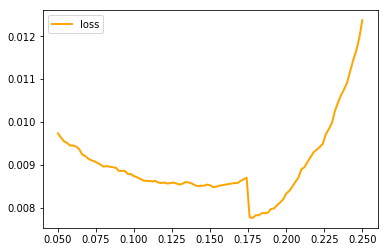

In [57]:
import matplotlib.pyplot as plt

x = np.arange(0.05, 0.252, 0.002)

fix, ax = plt.subplots(1)

ax.plot(x, results[:len(x)], marker='', color='orange', linewidth=2, label='loss')

plt.legend()

plt.savefig('hamming_loss.png')
plt.show()

In [58]:
results.index(min(results))

64

In [59]:
x[64]

0.1780000000000001